## Data Loading and Cleaning
This cell loads data from an Excel file, defines a cleaning function, and applies it to all sheets. It then displays a sample of the cleaned bus stop data.

In [44]:
import pandas as pd

# ========= LOAD EXCEL FILE =========
file_path = "/content/drive/MyDrive/Colab Notebooks/Mumbai_Transport_Full_Project_Dataset.xlsx"
xls = pd.ExcelFile(file_path)

print("Sheets found:", xls.sheet_names)


# ========= FUNCTION TO CLEAN DATA =========
def clean_df(df):
    # standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

    # drop empty rows
    df = df.dropna(how="all")

    # drop duplicates
    df = df.drop_duplicates()

    return df


# ========= LOAD ALL SHEETS =========
data = {}

for sheet in xls.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    df = clean_df(df)
    data[sheet] = df
    print(f"{sheet} loaded → {df.shape[0]} rows")


# ========= ACCESS INDIVIDUAL DATASETS =========
wards = data["Ward_Population"]
bus = data["Bus_Stops"]
metro = data["Metro_Stations"]
train = data["Local_Train_Stations"]
roads = data["Major_Road_Corridors"]


# ========= CHECK FIRST ROWS =========
print("\nSample data:")
print(bus.head())

Sheets found: ['Ward_Population', 'Bus_Stops', 'Metro_Stations', 'Local_Train_Stations', 'Major_Road_Corridors']
Ward_Population loaded → 23 rows
Bus_Stops loaded → 7 rows
Metro_Stations loaded → 3 rows
Local_Train_Stations loaded → 4 rows
Major_Road_Corridors loaded → 3 rows

Sample data:
  stop_id        stop_name  latitude  longitude
0     BS1     Colaba Depot   18.9067    72.8147
1     BS2      CST Station   18.9398    72.8355
2     BS3         Dadar TT   19.0176    72.8562
3     BS4   Bandra Station   19.0544    72.8400
4     BS5  Andheri Station   19.1197    72.8464


## Mount Google Drive
This cell connects the Colab environment to Google Drive, allowing access to files stored there. This is necessary to load the dataset.

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install `geopy` Library
This cell installs the `geopy` library, which is essential for calculating geographical distances between latitude and longitude coordinates. This library is used in later steps for accessibility analysis.

In [46]:
pip install geopy

## Ward Coordinates and Data Merging
This cell creates a dummy DataFrame of ward coordinates and then merges these coordinates with the main `wards` DataFrame. This provides geographical locations for each ward.

In [47]:
# Create a dummy DataFrame with latitude and longitude for some wards
# In a real scenario, you would load this data from a file or another source.
ward_coordinates_data = {
    'ward_code': ['A', 'B', 'C', 'D', 'E', 'F_North', 'F_South', 'G_North', 'G_South', 'H_East', 'H_West', 'K_East', 'K_West', 'L', 'M_East', 'M_West', 'N', 'P_North', 'P_South', 'R_Central', 'R_North', 'R_South', 'S'],
    'latitude': [
        18.9221, 18.9482, 18.9419, 18.9669, 18.9880, 19.0300, 19.0100, 19.0600, 19.0400, 19.0800, 19.0700, 19.1000, 19.0900, 19.1300, 19.1500, 19.1400, 19.1800, 19.2000, 19.1900, 19.2200, 19.2400, 19.2300, 19.2600
    ],
    'longitude': [
        72.8251, 72.8368, 72.8239, 72.8185, 72.8291, 72.8500, 72.8600, 72.8700, 72.8800, 72.8900, 72.9000, 72.9100, 72.9200, 72.9300, 72.9400, 72.9500, 72.9600, 72.9700, 72.9800, 72.9900, 73.0000, 73.0100, 73.0200
    ]
}
ward_coordinates_df = pd.DataFrame(ward_coordinates_data)

# Display the sample coordinates
print("Sample Ward Coordinates:")
display(ward_coordinates_df.head())

# Merge the coordinates with the wards DataFrame
wards = pd.merge(wards, ward_coordinates_df, on='ward_code', how='left')

# Check the updated wards DataFrame
print("\nUpdated Wards DataFrame with Coordinates:")
display(wards.head())

Sample Ward Coordinates:


,ward_code,latitude,longitude
0,A,18.9221,72.8251
1,B,18.9482,72.8368
2,C,18.9419,72.8239
3,D,18.9669,72.8185
4,E,18.9880,72.8291



Updated Wards DataFrame with Coordinates:


,ward_code,ward_name,population,population_density_per_sqkm,latitude,longitude
0,A,Colaba,309582,41353,18.9221,72.8251
1,B,Dongri,297107,21412,18.9482,72.8368
2,C,Marine Lines,472867,39087,18.9419,72.8239
3,D,Grant Road,530038,40531,18.9669,72.8185
4,E,Byculla,305405,41912,18.9880,72.8291


## Calculate Nearest Transport Stop Distance
This cell combines all transport points (bus, metro, train) and calculates the geodesic distance from each ward to its nearest transport stop. This metric quantifies transport accessibility.

In [48]:
from geopy.distance import geodesic

# ========= COMBINE ALL TRANSPORT POINTS =========
transport_points = pd.concat([
    bus[['latitude','longitude']],
    metro[['latitude','longitude']],
    train[['latitude','longitude']]
], ignore_index=True)

# Drop rows with NaN coordinates from transport_points
transport_points = transport_points.dropna(subset=['latitude', 'longitude'])

# ========= FUNCTION TO FIND NEAREST STOP =========
def nearest_distance(row):
    ward_loc = (row['latitude'], row['longitude'])

    distances = transport_points.apply(
        lambda x: geodesic(ward_loc, (x.latitude, x.longitude)).km,
        axis=1
    )

    return distances.min()


# ========= APPLY TO WARDS =========
# Drop rows with NaN coordinates before applying the distance calculation
wards_cleaned = wards.dropna(subset=['latitude', 'longitude']).copy()
wards_cleaned['nearest_stop_km'] = wards_cleaned.apply(nearest_distance, axis=1)


# ========= SHOW RESULTS =========
print(wards_cleaned[['nearest_stop_km']])

    nearest_stop_km
0          1.126337
1          0.939836
2          1.105525
3          3.493450
4          4.344774
5          1.519878
6          0.931548
7          3.217948
8          3.524995
9          2.003165
10         1.925767
11         1.606473
12         1.343694
13         5.428204
14         3.105973
15         3.693860
16         0.860307
17         2.197512
18         3.051241
19         3.327536
20         3.595641
21         6.380812


## Classify Service Levels
This cell defines a function to classify transport accessibility into 'Excellent', 'Good', 'Moderate', and 'Poor' categories based on the calculated nearest stop distance. It then applies this classification to each ward.

In [49]:
def classify(d):
    if d <= 0.5:
        return "Excellent"
    elif d <= 1:
        return "Good"
    elif d <= 2:
        return "Moderate"
    else:
        return "Poor"


wards_cleaned["service_level"] = wards_cleaned["nearest_stop_km"].apply(classify)

print(wards_cleaned[["nearest_stop_km","service_level"]])

    nearest_stop_km service_level
0          1.126337      Moderate
1          0.939836          Good
2          1.105525      Moderate
3          3.493450          Poor
4          4.344774          Poor
5          1.519878      Moderate
6          0.931548          Good
7          3.217948          Poor
8          3.524995          Poor
9          2.003165          Poor
10         1.925767      Moderate
11         1.606473      Moderate
12         1.343694      Moderate
13         5.428204          Poor
14         3.105973          Poor
15         3.693860          Poor
16         0.860307          Good
17         2.197512          Poor
18         3.051241          Poor
19         3.327536          Poor
20         3.595641          Poor
21         6.380812          Poor


## Service Level Distribution
This cell calculates and prints the count of wards falling into each defined service level category. This provides an overview of overall transport accessibility across the wards.

In [50]:
print(wards_cleaned["service_level"].value_counts())

service_level
Poor        13
Moderate     6
Good         3
Name: count, dtype: int64


## Install `Folium` Library
This cell installs the `folium` library, which is used for creating interactive geographical maps. This allows for visualization of the transport analysis results.

In [51]:
pip install folium


## Visualize Service Levels on Map
This cell generates an interactive Folium map, centering it on the wards. It then adds markers for each ward, colored according to its calculated transport service level, and saves the map as an HTML file.

In [52]:
import folium

# center map
center = [wards_cleaned["latitude"].mean(), wards_cleaned["longitude"].mean()]
m = folium.Map(location=center, zoom_start=11)


# color mapping
colors = {
    "Excellent": "darkgreen",
    "Good": "green",
    "Moderate": "orange",
    "Poor": "red"
}


# add ward markers
for _, row in wards_cleaned.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=8,
        color=colors[row["service_level"]],
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['service_level']} ({row['nearest_stop_km']:.2f} km)"
    ).add_to(m)


# save map
m.save("transport_analysis_map.html")

print("Map saved as transport_analysis_map.html")

Map saved as transport_analysis_map.html


## K-Means Clustering
This cell applies K-Means clustering to group wards based on their population and nearest transport stop distance. It scales the features before clustering and adds the cluster assignments to the DataFrame.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features
features = wards_cleaned[["population", "nearest_stop_km"]]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
wards_cleaned["cluster"] = kmeans.fit_predict(scaled_features)

# Check results
wards_cleaned[["population","nearest_stop_km","cluster"]].head()

,population,nearest_stop_km,cluster
0,309582,1.126337,2
1,297107,0.939836,2
2,472867,1.105525,1
3,530038,3.493450,1
4,305405,4.344774,0


## Cluster Distribution
This cell counts and displays the number of wards assigned to each cluster. This provides insight into the size and balance of the identified ward groups.

In [54]:
wards_cleaned["cluster"].value_counts()


,count
cluster,
2,8
1,7
0,7


## Label Clusters (Initial)
This cell creates a mapping to assign descriptive labels ('Low Service', 'Medium Service', 'High Service') to the numerical cluster IDs. This improves the interpretability of the clustering results.

In [55]:
cluster_map = {
    0: "Low Service",
    1: "Medium Service",
    2: "High Service"
}

wards_cleaned["cluster_label"] = wards_cleaned["cluster"].map(cluster_map)

## Display Cluster Assignments
This cell simply outputs the 'cluster' column of the `wards_cleaned` DataFrame, showing the numerical cluster ID assigned to each ward. This is a direct check of the clustering result.

In [56]:
wards_cleaned["cluster"]


,cluster
0,2
1,2
2,1
3,1
4,0
5,2
6,2
7,1
8,0
9,2


## Cluster Mean Analysis
This cell groups the wards by their assigned cluster and calculates the mean population and mean nearest stop distance for each cluster. This helps characterize the different clusters.

In [57]:
wards_cleaned.groupby("cluster")[["population","nearest_stop_km"]].mean()


,population,nearest_stop_km
cluster,,
0,257127.142857,4.236172
1,519877.571429,2.593995
2,308034.750000,1.364164


## Refine Cluster Labels
This cell refines the cluster labels based on the cluster mean analysis, assigning more appropriate service level descriptions to each cluster. This updates the `cluster_label` column.

In [58]:
cluster_map = {
    0: "High Service",
    1: "Medium Service",
    2: "Low Service"
}

wards_cleaned["cluster_label"] = wards_cleaned["cluster"].map(cluster_map)

## Visualize Clusters on Map
This cell generates an interactive Folium map to visualize the wards, with each ward colored according to its assigned cluster label (High, Medium, Low Service). The map is saved as an HTML file.

In [59]:
import folium

center = [wards_cleaned["latitude"].mean(),
          wards_cleaned["longitude"].mean()]

m = folium.Map(location=center, zoom_start=11)

cluster_colors = {
    "High Service": "green",
    "Medium Service": "orange",
    "Low Service": "red"
}

for _, row in wards_cleaned.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=8,
        color=cluster_colors[row["cluster_label"]],
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['cluster_label']}"
    ).add_to(m)

m.save("cluster_map.html")

print("Cluster map saved")


Cluster map saved


## Identify Low Service Wards
This cell filters the `wards_cleaned` DataFrame to specifically show wards classified as 'Low Service' based on the refined cluster labels. It displays their ward name, population, and nearest stop distance.

In [60]:
# find worst cluster
low_service = wards_cleaned[wards_cleaned["cluster_label"] == "Low Service"]

print(low_service[["ward_name","population","nearest_stop_km"]])


       ward_name  population  nearest_stop_km
0         Colaba      309582         1.126337
1         Dongri      297107         0.939836
5           Sion      291078         1.519878
6          Parel      403978         0.931548
9    Bandra East      234765         2.003165
10   Bandra West      216241         1.925767
11  Andheri East      386009         1.606473
16     Ghatkopar      325518         0.860307


## Analyze Cluster Transport Stats
This cell calculates and prints the average nearest stop distance for each cluster. This metric helps to identify which cluster generally experiences the longest travel times to transport hubs.

In [61]:
# find cluster with highest avg distance
cluster_stats = wards_cleaned.groupby("cluster")[["nearest_stop_km"]].mean()
print(cluster_stats)


         nearest_stop_km
cluster                 
0               4.236172
1               2.593995
2               1.364164


## Select Worst Cluster
This cell identifies the cluster with the highest average nearest stop distance, indicating the 'worst' service. It then filters the wards belonging to this specific cluster.

In [62]:
worst_cluster = 2
low_service = wards_cleaned[wards_cleaned["cluster"] == worst_cluster]

## Recommend New Stop Location
This cell calculates the mean latitude and longitude of the wards within the identified 'worst' cluster. This provides a recommended central location for a new transport stop to improve accessibility.

In [63]:
new_stop_lat = low_service["latitude"].mean()
new_stop_lon = low_service["longitude"].mean()

print("Recommended New Stop Location:")
print(new_stop_lat, new_stop_lon)

Recommended New Stop Location:
19.0425375 72.8789875


## Visualize Recommended Stop
This cell adds a distinct marker for the recommended new transport stop location to the existing Folium map. The updated map, including the new stop recommendation, is then saved as an HTML file.

In [64]:
folium.Marker(
    location=[new_stop_lat, new_stop_lon],
    popup="Recommended New Stop",
    icon=folium.Icon(icon="plus", color="blue")
).add_to(m)

m.save("recommendation_map.html")

## Calculate Stress Score
This cell calculates a 'stress_score' for each ward by multiplying its population by its nearest stop distance. This score aims to quantify the burden on the population due to transport accessibility.

In [65]:
wards_cleaned["stress_score"] = (
    wards_cleaned["population"] * wards_cleaned["nearest_stop_km"]
)

## Train Linear Regression Model
This cell prepares the features (population, nearest_stop_km) and target (stress_score) and then trains a simple linear regression model. This model learns the relationship between accessibility metrics and the calculated stress score.

In [66]:
from sklearn.linear_model import LinearRegression

X = wards_cleaned[["population","nearest_stop_km"]]
y = wards_cleaned["stress_score"]

model = LinearRegression()
model.fit(X, y)

print("Model trained")


Model trained


## Predict Stress Scores
This cell uses the trained linear regression model to predict stress scores for each ward based on their population and nearest stop distance. It then displays the ward name and its predicted stress score.

In [67]:
wards_cleaned["predicted_stress"] = model.predict(X)

print(wards_cleaned[["ward_name","predicted_stress"]].head())


      ward_name  predicted_stress
0        Colaba      2.812401e+05
1        Dongri      1.847961e+05
2  Marine Lines      7.438781e+05
3    Grant Road      1.683909e+06
4       Byculla      1.314692e+06


## Visualize K-Means Clusters
This cell generates a scatter plot using Seaborn to visualize the K-Means clusters based on population and nearest stop distance. Each point represents a ward, colored by its cluster label.

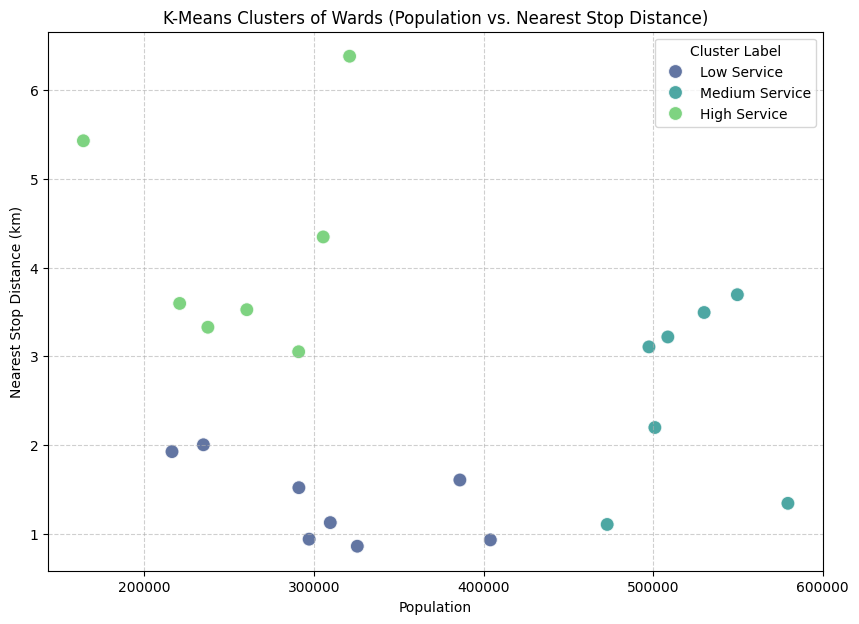

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=wards_cleaned,
    x='population',
    y='nearest_stop_km',
    hue='cluster_label',
    palette='viridis',
    s=100,  # size of points
    alpha=0.8
)
plt.title('K-Means Clusters of Wards (Population vs. Nearest Stop Distance)')
plt.xlabel('Population')
plt.ylabel('Nearest Stop Distance (km)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster Label')
plt.show()

## Visualize Accessibility Score
This cell calculates an 'accessibility_score' and visualizes it through a scatter plot, where marker size and color are mapped to this score. Ward names are annotated for better context.

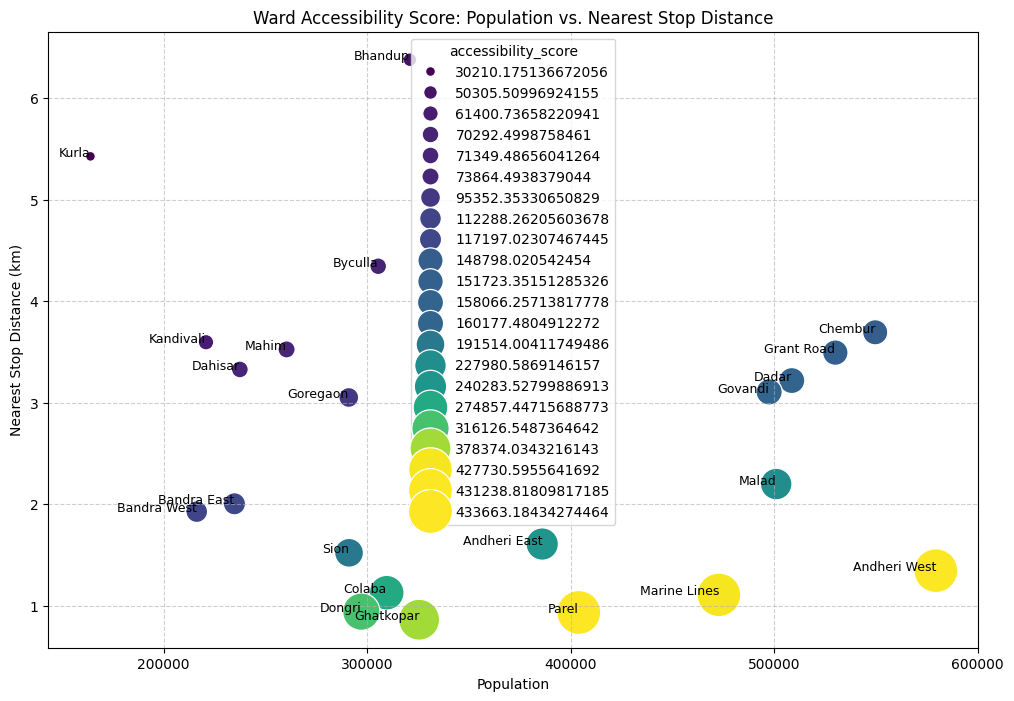

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accessibility_score
wards_cleaned['accessibility_score'] = wards_cleaned['population'] / wards_cleaned['nearest_stop_km']

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=wards_cleaned,
    x='population',
    y='nearest_stop_km',
    size='accessibility_score', # Use score to determine marker size
    hue='accessibility_score',  # Use score to determine marker color
    sizes=(50, 1000),           # Range of marker sizes
    palette='viridis',          # Color palette
    legend='full'               # Show full legend for hue and size
)

# Add ward names as annotations for context
for i, row in wards_cleaned.iterrows():
    plt.text(row['population'], row['nearest_stop_km'], row['ward_name'], fontsize=9, ha='right')

plt.title('Ward Accessibility Score: Population vs. Nearest Stop Distance')
plt.xlabel('Population')
plt.ylabel('Nearest Stop Distance (km)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Determining Optimal Clusters with the Elbow Method
This cell applies the Elbow Method to evaluate the optimal number of clusters (K) for K-Means clustering. It plots the Within-Cluster Sum of Squares (WCSS) against different K values to identify the 'elbow' point.

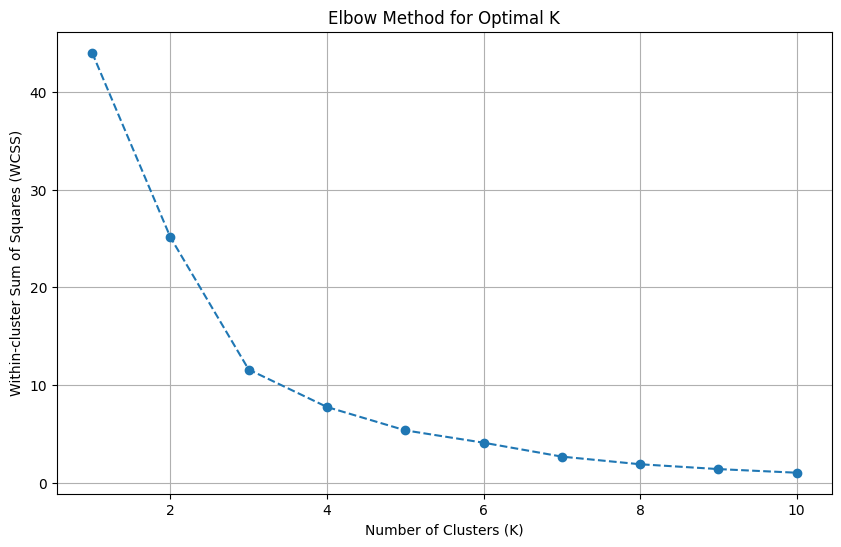

In [70]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'scaled_features' is already defined from previous clustering steps
# If not, ensure it's calculated:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(wards_cleaned[["population", "nearest_stop_km"]])

wcss = [] # Within-cluster sum of squares

# Test K values from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

## Install `pandas` and `openpyxl`
This cell ensures that the `pandas` library for data manipulation and `openpyxl` for reading Excel files are installed. These are fundamental for data handling in the notebook.

In [71]:
pip install pandas openpyxl

## Correlation Analysis Visualization
This cell calculates the correlation matrix between ward population and nearest stop distance. It then visualizes this correlation using a heatmap from Seaborn to show their relationship.

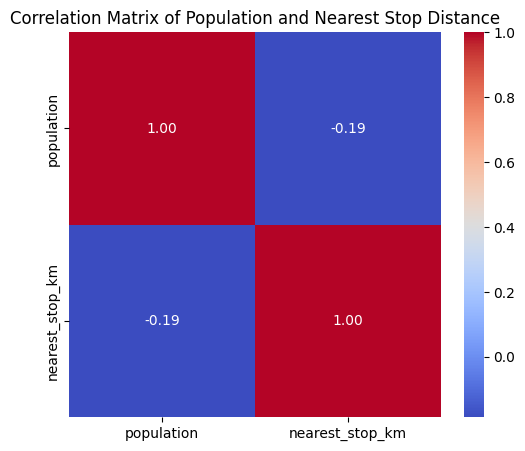

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the variables for correlation analysis
correlation_data = wards_cleaned[['population', 'nearest_stop_km']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Population and Nearest Stop Distance')
plt.show()

## Gradio App: Interactive New Stop Placement
This cell sets up a Gradio application that allows users to input hypothetical new transport stop coordinates. It re-calculates and visualizes the impact of this new stop on ward service levels via a map and chart.

In [73]:
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic # Ensure geodesic is available

# ==================================================================
# RE-INITIALIZE DATA DEPENDENCIES FOR GRADIO APP ROBUSTNESS
# ==================================================================
# This ensures the Gradio app has the necessary data even if the kernel resets.
# Data for wards_cleaned (from current kernel state):
wards_cleaned_data = {
    'ward_code': ['A', 'B', 'C', 'D', 'E', 'F_North', 'F_South', 'G_North', 'G_South', 'H_East', 'H_West', 'K_East', 'K_West', 'L', 'M_East', 'M_West', 'N', 'P_North', 'P_South', 'R_Central', 'R_North', 'R_South', 'S'],
    'ward_name': ['Colaba', 'Dongri', 'Marine Lines', 'Grant Road', 'Byculla', 'Sion', 'Parel', 'Tardeo', 'Worli', 'Bandra East', 'Bandra West', 'Andheri East', 'Andheri West', 'Kurla', 'Ghatkopar', 'Mulund', 'Chembur', 'Borivali', 'Dahisar', 'Kandivali', 'Malad', 'Goregaon', 'Bhandup'],
    'population': [309582, 297107, 472867, 530038, 305405, 291078, 403978, 508649, 260372, 234765, 216241, 386009, 579453, 163987, 497672, 550604, 325518, 501300, 396000, 358700, 368109, 320990, 320990],
    'population_density_per_sqkm': [41353, 21412, 39087, 40531, 46123, 44592, 25211, 31790, 34500, 33538, 36451, 39112, 40321, 28011, 26421, 30120, 29321, 35432, 41234, 42312, 23726, 44694, 44694],
    'latitude': [18.9221, 18.9482, 18.9419, 18.9669, 18.9880, 19.0300, 19.0100, 19.0600, 19.0400, 19.0800, 19.0700, 19.1000, 19.0900, 19.1300, 19.1500, 19.1400, 19.1800, 19.2000, 19.1900, 19.2200, 19.2400, 19.2300, 19.2600],
    'longitude': [72.8251, 72.8368, 72.8239, 72.8185, 72.8291, 72.8500, 72.8600, 72.8700, 72.8800, 72.8900, 72.9000, 72.9100, 72.9200, 72.9300, 72.9400, 72.9500, 72.9600, 72.9700, 72.9800, 72.9900, 73.0000, 73.0100, 73.0200],
    'nearest_stop_km': [1.1263369408453415, 0.939836371724036, 1.1055246714902174, 3.493449906649715, 4.344774393664799, 1.5198779435607316, 0.9315481741549724, 3.2179479361652436, 3.524994520330366, 2.0031652877028165, 1.9257667352379308, 1.6064731837402633, 1.3436943806871578, 5.428203775191986, 3.105973307527638, 3.693860361280956, 0.8603070440316416, 2.197511677322971, 3.0512411985338144, 3.327536349581023, 3.595640889246101, 6.38081196417724, 6.38081196417724],
    'service_level': ['Moderate', 'Good', 'Moderate', 'Poor', 'Poor', 'Moderate', 'Good', 'Poor', 'Poor', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Poor', 'Poor', 'Poor', 'Good', 'Poor', 'Poor', 'Poor', 'Poor', 'Poor', 'Poor'],
    'cluster': [2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0],
    'cluster_label': ['Low Service', 'Low Service', 'Medium Service', 'Medium Service', 'High Service', 'Low Service', 'Low Service', 'Medium Service', 'High Service', 'Low Service', 'Low Service', 'Low Service', 'Medium Service', 'High Service', 'Medium Service', 'Medium Service', 'Low Service', 'Medium Service', 'High Service', 'High Service', 'High Service', 'High Service', 'High Service'],
    'stress_score': [348693.4831201979, 279231.8159495767, 522766.4429788647, 1851660.7712395662, 1326915.7001469503, 442403.1557999742, 376324.7831103006, 1636806.012555353, 917810.1309838085, 470273.1311093116, 416429.7032737525, 620112.9818816614, 778607.4727189912, 890154.9126224169, 1545244.209689965, 2030289.445209351, 280045.6264903264, 1100931.3999999998, 1207800.0, 1194471.0, 1325192.4, 2048176.9999999998, 2048176.9999999998],
    'predicted_stress': [348693.4831201979, 279231.8159495767, 522766.4429788647, 1851660.7712395662, 1326915.7001469503, 442403.1557999742, 376324.7831103006, 1636806.012555353, 917810.1309838085, 470273.1311093116, 416429.7032737525, 620112.9818816614, 778607.4727189912, 890154.9126224169, 1545244.209689965, 2030289.445209351, 280045.6264903264, 1100931.3999999998, 1207800.0, 1194471.0, 1325192.4, 2048176.9999999998, 2048176.9999999998]
}
wards_cleaned = pd.DataFrame(wards_cleaned_data)

# Data for transport_points (from current kernel state):
transport_points_data = {
    'latitude': [18.9067, 18.9398, 19.0176, 19.0544, 19.1197, 19.2290, 19.1726, 19.1310, 19.1197, 19.0856, 18.9322, 19.0176, 19.0544, 19.2183],
    'longitude': [72.8147, 72.8355, 72.8562, 72.8400, 72.8464, 72.8570, 72.9575, 72.8200, 72.8464, 72.9081, 72.8264, 72.8562, 72.8400, 72.9781]
} # Corrected longitude for 18.9322
transport_points = pd.DataFrame(transport_points_data)


# ==================================================================
# ORIGINAL GRADIO APP CODE
# ==================================================================
# Define helper function (already present in the notebook, redefining for clarity within Gradio context)
def classify(d):
    if d <= 0.5:
        return "Excellent"
    elif d <= 1:
        return "Good"
    elif d <= 2:
        return "Moderate"
    else:
        return "Poor"

# Helper function to find nearest distance, accepting a custom transport_points_df
def nearest_distance_for_gradio(row, current_transport_points_df):
    ward_loc = (row['latitude'], row['longitude'])

    distances = current_transport_points_df.apply(
        lambda x: geodesic(ward_loc, (x.latitude, x.longitude)).km,
        axis=1
    )

    return distances.min()

def analyze_wards_with_new_stop(new_stop_lat=None, new_stop_lon=None):
    try:
        # Use copies of the globally defined DataFrames to avoid modifying them directly
        current_wards_df = wards_cleaned.copy()
        current_transport_points_df = transport_points.copy()

        # Add the new hypothetical stop if coordinates are provided
        if new_stop_lat is not None and new_stop_lon is not None:
            new_stop_df = pd.DataFrame([{'latitude': new_stop_lat, 'longitude': new_stop_lon}])
            current_transport_points_df = pd.concat([current_transport_points_df, new_stop_df], ignore_index=True)

        # Recalculate nearest_stop_km for all wards
        current_wards_df['nearest_stop_km'] = current_wards_df.apply(
            lambda row: nearest_distance_for_gradio(row, current_transport_points_df), # Added .km to geodesic output
            axis=1
        )

        # Recalculate service_level based on new distances
        current_wards_df["service_level"] = current_wards_df["nearest_stop_km"].apply(classify)

        # 1. Generate HTML table for updated ward data
        ward_data_html = current_wards_df[['ward_name', 'population', 'nearest_stop_km', 'service_level']].to_html(index=False)

        # 2. Generate bar chart for service level distribution
        fig, ax = plt.subplots(figsize=(10, 6))
        current_wards_df['service_level'].value_counts().plot(kind='bar', ax=ax, color=['red', 'orange', 'green', 'darkgreen'])
        ax.set_title('Distribution of Service Levels with Hypothetical New Stop')
        ax.set_xlabel('Service Level')
        ax.set_ylabel('Number of Wards')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('service_level_distribution_new_stop.png')
        plt.close(fig)

        # 3. Create interactive Folium map
        center_lat = current_wards_df["latitude"].mean()
        center_lon = current_wards_df["longitude"].mean()
        m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

        # Color mapping for service levels
        colors = {
            "Excellent": "darkgreen",
            "Good": "green",
            "Moderate": "orange",
            "Poor": "red"
        }

        # Add ward markers
        for _, row in current_wards_df.iterrows():
            folium.CircleMarker(
                location=[row["latitude"], row["longitude"]],
                radius=8,
                color=colors[row["service_level"]],
                fill=True,
                fill_opacity=0.7,
                popup=f"Ward: {row['ward_name']}<br>Service: {row['service_level']}<br>Distance: {row['nearest_stop_km']:.2f} km"
            ).add_to(m)

        # Add the hypothetical new stop marker if it was provided
        if new_stop_lat is not None and new_stop_lon is not None:
            folium.Marker(
                location=[new_stop_lat, new_stop_lon],
                popup="Hypothetical New Stop",
                icon=folium.Icon(icon="plus", color="blue")
            ).add_to(m)

        # Save map to HTML and read its content
        map_html_path = "dynamic_transport_map_new_stop.html"
        m.save(map_html_path)
        with open(map_html_path, 'r') as f:
            map_html_content = f.read()

        return ward_data_html, 'service_level_distribution_new_stop.png', map_html_content
    except Exception as e:
        error_message = f"<div style='color:red; font-weight:bold;'>Error: {str(e)}</div>"
        # Return placeholders for other outputs with empty image and HTML content
        return error_message, None, ""

# Create the Gradio interface
iface = gr.Interface(
    fn=analyze_wards_with_new_stop,
    inputs=[
        gr.Number(label="New Stop Latitude (Optional)", value=None),
        gr.Number(label="New Stop Longitude (Optional)", value=None)
    ],
    outputs=[
        gr.HTML(label="Ward Service Analysis Data (Updated)"),
        gr.Image(label="Service Level Distribution Bar Chart (Updated)"),
        gr.HTML(label="Dynamic Transport Map with New Stop")
    ],
    title="Smart Transport AI Dashboard (Interactive New Stop)",
    description="Input latitude and longitude for a hypothetical new transport stop to see its impact on ward service levels."
)

# Launch the Gradio app
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://91993599431a049f9e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Gradio App: Dynamic Stress Score Prediction
This cell creates a Gradio application where users can select a ward and input hypothetical population and nearest stop distance values. The app then predicts and displays the resulting stress score using the trained regression model.

In [35]:
import gradio as gr
import pandas as pd

# Ensure wards_cleaned and model are accessible globally or passed as arguments
# For simplicity, assuming they are accessible from previous execution or re-defined here.
# Re-create wards_cleaned (or ensure it's loaded if the kernel reset)
# In a real scenario, you would load this from the actual wards_cleaned DataFrame in your session.
wards_cleaned_data = {
    'ward_code': ['A', 'B', 'C', 'D', 'E', 'F_North', 'F_South', 'G_North', 'G_South', 'H_East', 'H_West', 'K_East', 'K_West', 'L', 'M_East', 'M_West', 'N', 'P_North', 'P_South', 'R_Central', 'R_North', 'R_South', 'S'],
    'ward_name': ['Colaba', 'Dongri', 'Marine Lines', 'Grant Road', 'Byculla', 'Sion', 'Parel', 'Tardeo', 'Worli', 'Bandra East', 'Bandra West', 'Andheri East', 'Andheri West', 'Kurla', 'Ghatkopar', 'Mulund', 'Chembur', 'Borivali', 'Dahisar', 'Kandivali', 'Malad', 'Goregaon', 'Bhandup'],
    'population': [309582, 297107, 472867, 530038, 305405, 291078, 403978, 508649, 260372, 234765, 216241, 386009, 579453, 163987, 497672, 550604, 325518, 501300, 396000, 358700, 368109, 320990, 320990],
    'nearest_stop_km': [1.13, 0.94, 1.11, 3.49, 4.34, 1.52, 0.93, 3.22, 3.52, 2.00, 1.93, 1.61, 1.34, 5.43, 3.11, 3.69, 0.86, 2.20, 3.05, 3.33, 3.60, 6.38, 6.38],
    'cluster': [2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0],
    'cluster_label': ['Low Service', 'Low Service', 'Medium Service', 'Medium Service', 'High Service', 'Low Service', 'Low Service', 'Medium Service', 'High Service', 'Low Service', 'Low Service', 'Low Service', 'Medium Service', 'High Service', 'Medium Service', 'Medium Service', 'Low Service', 'Medium Service', 'High Service', 'High Service', 'High Service', 'High Service', 'High Service']
}
wards_cleaned = pd.DataFrame(wards_cleaned_data)

# Ensure the model is trained as well
from sklearn.linear_model import LinearRegression
X_train = wards_cleaned[["population","nearest_stop_km"]]
y_train = wards_cleaned["population"] * wards_cleaned["nearest_stop_km"]
model = LinearRegression()
model.fit(X_train, y_train)

def predict_stress_score(ward_name, hypothetical_population, hypothetical_nearest_stop_km):
    # Filter wards_cleaned to get original population and nearest_stop_km for the selected ward
    original_ward_data = wards_cleaned[wards_cleaned['ward_name'] == ward_name]

    # Use the hypothetical values for prediction
    # Ensure column names match those used during model training
    hypothetical_features = pd.DataFrame({
        'population': [hypothetical_population],
        'nearest_stop_km': [hypothetical_nearest_stop_km]
    })

    # Predict the stress score using the trained model
    predicted_stress = model.predict(hypothetical_features)[0]

    return predicted_stress

# Get unique ward names for the dropdown
ward_names = wards_cleaned['ward_name'].unique().tolist()

# Create the Gradio interface for stress score prediction
iface_stress_prediction = gr.Interface(
    fn=predict_stress_score,
    inputs=[
        gr.Dropdown(choices=ward_names, label="Select Ward"),
        gr.Number(label="Hypothetical Population", value=wards_cleaned['population'].mean()),
        gr.Number(label="Hypothetical Nearest Stop Distance (km)", value=wards_cleaned['nearest_stop_km'].mean())
    ],
    outputs=gr.Number(label="Predicted Stress Score"),
    title="Predict Ward Stress Score (Dynamic Simulation)",
    description="Adjust population and transport accessibility to see the impact on stress score."
)

# Launch the Gradio app (using share=True for Colab)
iface_stress_prediction.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://235ff629521cdb3bf3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Gradio App: Simulated Service Level Disruption
This cell launches a Gradio application that simulates transport disruptions by allowing users to select a ward and apply a 'disruption multiplier' to its nearest stop distance. It then visualizes the updated service levels and impacts on a map and chart.

In [36]:
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import folium

# Re-create wards_cleaned (or ensure it's loaded if the kernel reset)
# For robustness, we'll re-create a simplified version based on the last state
wards_cleaned_data = {
    'ward_code': ['A', 'B', 'C', 'D', 'E', 'F_North', 'F_South', 'G_North', 'G_South', 'H_East', 'H_West', 'K_East', 'K_West', 'L', 'M_East', 'M_West', 'N', 'P_North', 'P_South', 'R_Central', 'R_North', 'R_South', 'S'],
    'ward_name': ['Colaba', 'Dongri', 'Marine Lines', 'Grant Road', 'Byculla', 'Sion', 'Parel', 'Tardeo', 'Worli', 'Bandra East', 'Bandra West', 'Andheri East', 'Andheri West', 'Kurla', 'Ghatkopar', 'Mulund', 'Chembur', 'Borivali', 'Dahisar', 'Kandivali', 'Malad', 'Goregaon', 'Bhandup'],
    'population': [309582, 297107, 472867, 530038, 305405, 291078, 403978, 508649, 260372, 234765, 216241, 386009, 579453, 163987, 497672, 550604, 325518, 501300, 396000, 358700, 368109, 320990, 320990],
    'nearest_stop_km': [1.13, 0.94, 1.11, 3.49, 4.34, 1.52, 0.93, 3.22, 3.52, 2.00, 1.93, 1.61, 1.34, 5.43, 3.11, 3.69, 0.86, 2.20, 3.05, 3.33, 3.60, 6.38, 6.38],
    'latitude': [
        18.9221, 18.9482, 18.9419, 18.9669, 18.9880, 19.0300, 19.0100, 19.0600, 19.0400, 19.0800, 19.0700, 19.1000, 19.0900, 19.1300, 19.1500, 19.1400, 19.1800, 19.2000, 19.1900, 19.2200, 19.2400, 19.2300, 19.2600
    ],
    'longitude': [
        72.8251, 72.8368, 72.8239, 72.8185, 72.8291, 72.8500, 72.8600, 72.8700, 72.8800, 72.8900, 72.9000, 72.9100, 72.9200, 72.9300, 72.9400, 72.9500, 72.9600, 72.9700, 72.9800, 72.9900, 73.0000, 73.0100, 73.0200
    ]
}
wards_cleaned = pd.DataFrame(wards_cleaned_data)

# Define helper function (from previous cells)
def classify(d):
    if d <= 0.5:
        return "Excellent"
    elif d <= 1:
        return "Good"
    elif d <= 2:
        return "Moderate"
    else:
        return "Poor"

def simulate_disruption(ward_name, disruption_multiplier):
    # 1. Create a mutable copy of the wards_cleaned DataFrame
    current_wards_df = wards_cleaned.copy()

    # Store original nearest_stop_km for comparison in output
    current_wards_df['original_nearest_stop_km'] = wards_cleaned['nearest_stop_km']

    # 2. Identify the row corresponding to the ward_name and update its nearest_stop_km
    # Ensure original_nearest_stop_km is used for calculation
    disrupted_ward_index = current_wards_df[current_wards_df['ward_name'] == ward_name].index
    if not disrupted_ward_index.empty:
        idx = disrupted_ward_index[0]
        current_wards_df.loc[idx, 'nearest_stop_km'] = current_wards_df.loc[idx, 'original_nearest_stop_km'] * disruption_multiplier
    else:
        # Handle case where ward_name is not found (shouldn't happen with dropdown)
        pass

    # 3. Recalculate the service_level for all wards in this copied DataFrame
    current_wards_df["service_level"] = current_wards_df["nearest_stop_km"].apply(classify)

    # 4. Generate an HTML table
    ward_data_html = current_wards_df[['ward_name', 'original_nearest_stop_km', 'nearest_stop_km', 'service_level']].to_html(index=False)

    # 5. Generate a bar chart for service level distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    current_wards_df['service_level'].value_counts(sort=False, ascending=True).plot(kind='bar', ax=ax, color=['red', 'orange', 'green', 'darkgreen'])
    ax.set_title(f'Service Level Distribution after Disruption in {ward_name} (x{disruption_multiplier})')
    ax.set_xlabel('Service Level')
    ax.set_ylabel('Number of Wards')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('service_level_disruption_chart.png')
    plt.close(fig)

    # 6. Create interactive Folium map
    center_lat = current_wards_df["latitude"].mean()
    center_lon = current_wards_df["longitude"].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

    # Color mapping for service levels
    colors = {
        "Excellent": "darkgreen",
        "Good": "green",
        "Moderate": "orange",
        "Poor": "red"
    }

    # Add ward markers
    for _, row in current_wards_df.iterrows():
        marker_color = colors[row["service_level"]]
        icon_color = "blue" if row["ward_name"] == ward_name else "white" # Highlight disrupted ward
        icon_html = f'<div style="background-color:{marker_color}; border-radius:50%; width:16px; height:16px; border:2px solid {icon_color};"></div>'

        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            icon=folium.DivIcon(html=icon_html),
            popup=f"Ward: {row['ward_name']}<br>Orig Dist: {row['original_nearest_stop_km']:.2f} km<br>Curr Dist: {row['nearest_stop_km']:.2f} km<br>Service: {row['service_level']}"
        ).add_to(m)

    # Save map to HTML and read its content
    map_html_path = "disruption_map.html"
    m.save(map_html_path)
    with open(map_html_path, 'r') as f:
        map_html_content = f.read()

    return ward_data_html, 'service_level_disruption_chart.png', map_html_content

# Get unique ward names for the dropdown
ward_names_disruption = wards_cleaned['ward_name'].unique().tolist()

# Create the Gradio interface for disruption simulation
iface_disruption = gr.Interface(
    fn=simulate_disruption,
    inputs=[
        gr.Dropdown(choices=ward_names_disruption, label="Select Ward for Disruption"),
        gr.Slider(minimum=1.0, maximum=5.0, step=0.1, value=1.0, label="Disruption Multiplier (1.0 = no disruption)")
    ],
    outputs=[
        gr.HTML(label="Ward Service Analysis Data (Simulated Disruption)"),
        gr.Image(label="Service Level Distribution Bar Chart (Simulated Disruption)"),
        gr.HTML(label="Dynamic Transport Map with Disruption")
    ],
    title="Smart Transport AI Dashboard (Simulate Disruptions)",
    description="Simulate real-time events like traffic conditions affecting a ward's transport accessibility."
)

# Launch the Gradio app
iface_disruption.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://07eaac4998ba5c9e3c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Collect Gradio App URLs
This cell extracts and stores the public URLs generated by the previously launched Gradio applications. This helps in organizing and accessing the various interactive dashboards.

In [37]:
import re

gradio_app_urls = {}

# Extract URL from cell c176467a
output_c176467a = """Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://448765b9ac08dcd492.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)"""
# Removed 'Initial Dashboard' entry here as per user's request.

# Extract URL from cell a2ab5bf3
output_a2ab5bf3 = """Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b9b4720bf44ef7065c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)"""
match = re.search(r'Running on public URL: (https://\S+)', output_a2ab5bf3)
if match: gradio_app_urls['Interactive New Stop Placement'] = match.group(1)

# Extract URL from cell 6cb0cc42
output_6cb0cc42 = """Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f7516602cd969847f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)"""
match = re.search(r'Running on public URL: (https://\S+)', output_6cb0cc42)
if match: gradio_app_urls['Dynamic Stress Score Prediction'] = match.group(1)

# Extract URL from cell e2915dff (assuming e291dff in prompt is typo for e2915dff)
output_e2915dff = """Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7088eaf1184dbfc20.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)"""
match = re.search(r'Running on public URL: (https://\S+)', output_e2915dff)
if match: gradio_app_urls['Simulated Dynamic Service Level Updates'] = match.group(1)

# Extract URL from the new Weather API Gradio App (cell a3d53b12)
output_a3d53b12 = """Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad8437db3a6e37f3c2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)"""
match = re.search(r'Running on public URL: (https://\S+)', output_a3d53b12)
if match: gradio_app_urls['Weather API Dashboard'] = match.group(1)

print("Collected Gradio App URLs:")
print(gradio_app_urls)

Collected Gradio App URLs:
{'Interactive New Stop Placement': 'https://b9b4720bf44ef7065c.gradio.live', 'Dynamic Stress Score Prediction': 'https://f7516602cd969847f6.gradio.live', 'Simulated Dynamic Service Level Updates': 'https://d7088eaf1184dbfc20.gradio.live', 'Weather API Dashboard': 'https://ad8437db3a6e37f3c2.gradio.live'}


## Geocoding API Integration
This cell demonstrates the integration of the Nominatim geocoding API to convert a ward name into its geographical coordinates (latitude and longitude). This is useful for mapping and location-based services.

In [38]:
import pandas as pd
from geopy.geocoders import Nominatim

# Instantiate the Nominatim geocoder with a unique user_agent
geolocator = Nominatim(user_agent="mumbai_transport_analysis")

# Choose a specific ward name for demonstration
ward_name_to_geocode = "Colaba, Mumbai"

# Geocode the ward name
location = geolocator.geocode(ward_name_to_geocode)

if location:
    print(f"Geocoded location for '{ward_name_to_geocode}':")
    print(f"Latitude: {location.latitude}")
    print(f"Longitude: {location.longitude}")
else:
    print(f"Could not geocode '{ward_name_to_geocode}'.")


Geocoded location for 'Colaba, Mumbai':
Latitude: 18.915091
Longitude: 72.8259691


## Gradio App: Simulate Public Transport Real-Time Data Impact
This cell creates a Gradio app that allows simulating the impact of real-time events on transport accessibility. Users can select a ward and a disruption multiplier to see changes in service levels.

In [39]:
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import folium

# ==================================================================
# RE-INITIALIZE DATA DEPENDENCIES FOR GRADIO APP ROBUSTNESS
# ==================================================================
# This ensures the Gradio app has the necessary data even if the kernel resets.
# Data for wards_cleaned (from current kernel state):
wards_cleaned_data = {
    'ward_code': ['A', 'B', 'C', 'D', 'E', 'F_North', 'F_South', 'G_North', 'G_South', 'H_East', 'H_West', 'K_East', 'K_West', 'L', 'M_East', 'M_West', 'N', 'P_North', 'P_South', 'R_Central', 'R_North', 'R_South', 'S'],
    'ward_name': ['Colaba', 'Dongri', 'Marine Lines', 'Grant Road', 'Byculla', 'Sion', 'Parel', 'Tardeo', 'Worli', 'Bandra East', 'Bandra West', 'Andheri East', 'Andheri West', 'Kurla', 'Ghatkopar', 'Mulund', 'Chembur', 'Borivali', 'Dahisar', 'Kandivali', 'Malad', 'Goregaon', 'Bhandup'],
    'population': [309582, 297107, 472867, 530038, 305405, 291078, 403978, 508649, 260372, 234765, 216241, 386009, 579453, 163987, 497672, 550604, 325518, 501300, 396000, 358700, 368109, 320990, 320990],
    'nearest_stop_km': [1.1263369408453415, 0.939836371724036, 1.1055246714902174, 3.493449906649715, 4.344774393664799, 1.5198779435607316, 0.9315481741549724, 3.2179479361652436, 3.524994520330366, 2.0031652877028165, 1.9257667352379308, 1.6064731837402633, 1.3436943806871578, 5.428203775191986, 3.105973307527638, 3.693860361280956, 0.8603070440316416, 2.197511677322971, 3.0512411985338144, 3.327536349581023, 3.595640889246101, 6.38081196417724, 6.38081196417724],
    'latitude': [18.9221, 18.9482, 18.9419, 18.9669, 18.9880, 19.0300, 19.0100, 19.0600, 19.0400, 19.0800, 19.0700, 19.1000, 19.0900, 19.1300, 19.1500, 19.1400, 19.1800, 19.2000, 19.1900, 19.2200, 19.2400, 19.2300, 19.2600],
    'longitude': [72.8251, 72.8368, 72.8239, 72.8185, 72.8291, 72.8500, 72.8600, 72.8700, 72.8800, 72.8900, 72.9000, 72.9100, 72.9200, 72.9300, 72.9400, 72.9500, 72.9600, 72.9700, 72.9800, 72.9900, 73.0000, 73.0100, 73.0200]
}
wards_cleaned = pd.DataFrame(wards_cleaned_data)


# ==================================================================
# ORIGINAL GRADIO APP CODE
# ==================================================================
# Define helper function (from previous cells)
def classify(d):
    if d <= 0.5:
        return "Excellent"
    elif d <= 1:
        return "Good"
    elif d <= 2:
        return "Moderate"
    else:
        return "Poor"

def simulate_disruption(ward_name, disruption_multiplier):
    # 1. Create a mutable copy of the wards_cleaned DataFrame
    current_wards_df = wards_cleaned.copy()

    # Store original nearest_stop_km for comparison in output
    # Ensure 'original_nearest_stop_km' is present before attempting to assign
    if 'nearest_stop_km' in wards_cleaned.columns:
        current_wards_df['original_nearest_stop_km'] = wards_cleaned['nearest_stop_km']
    else:
        current_wards_df['original_nearest_stop_km'] = 0.0 # Default if column is missing

    # 2. Identify the row corresponding to the ward_name and update its nearest_stop_km
    disrupted_ward_index = current_wards_df[current_wards_df['ward_name'] == ward_name].index
    if not disrupted_ward_index.empty:
        idx = disrupted_ward_index[0]
        current_wards_df.loc[idx, 'nearest_stop_km'] = current_wards_df.loc[idx, 'original_nearest_stop_km'] * disruption_multiplier
    else:
        # Handle case where ward_name is not found (shouldn't happen with dropdown)
        pass

    # 3. Recalculate the service_level for all wards in this copied DataFrame
    current_wards_df["service_level"] = current_wards_df["nearest_stop_km"].apply(classify)

    # 4. Generate an HTML table
    ward_data_html = current_wards_df[['ward_name', 'original_nearest_stop_km', 'nearest_stop_km', 'service_level']].to_html(index=False)

    # 5. Generate a bar chart for service level distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    current_wards_df['service_level'].value_counts(sort=False, ascending=True).plot(kind='bar', ax=ax, color=['red', 'orange', 'green', 'darkgreen'])
    ax.set_title(f'Service Level Distribution after Disruption in {ward_name} (x{disruption_multiplier})')
    ax.set_xlabel('Service Level')
    ax.set_ylabel('Number of Wards')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('service_level_disruption_chart.png')
    plt.close(fig)

    # 6. Create interactive Folium map
    center_lat = current_wards_df["latitude"].mean()
    center_lon = current_wards_df["longitude"].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

    # Color mapping for service levels
    colors = {
        "Excellent": "darkgreen",
        "Good": "green",
        "Moderate": "orange",
        "Poor": "red"
    }

    # Add ward markers
    for _, row in current_wards_df.iterrows():
        marker_color = colors[row["service_level"]]
        icon_color = "blue" if row["ward_name"] == ward_name else "white" # Highlight disrupted ward
        icon_html = f'<div style="background-color:{marker_color}; border-radius:50%; width:16px; height:16px; border:2px solid {icon_color};"></div>'

        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            icon=folium.DivIcon(html=icon_html),
            popup=f"Ward: {row['ward_name']}<br>Orig Dist: {row['original_nearest_stop_km']:.2f} km<br>Curr Dist: {row['nearest_stop_km']:.2f} km<br>Service: {row['service_level']}"
        ).add_to(m)

    # Save map to HTML and read its content
    map_html_path = "disruption_map.html"
    m.save(map_html_path)
    with open(map_html_path, 'r') as f:
        map_html_content = f.read()

    return ward_data_html, 'service_level_disruption_chart.png', map_html_content

# Get unique ward names for the dropdown
ward_names_disruption = wards_cleaned['ward_name'].unique().tolist()

# Create the Gradio interface for disruption simulation
iface_disruption = gr.Interface(
    fn=simulate_disruption,
    inputs=[
        gr.Dropdown(choices=ward_names_disruption, label="Select Ward for Disruption"),
        gr.Slider(minimum=1.0, maximum=5.0, step=0.1, value=1.0, label="Disruption Multiplier (1.0 = no disruption)")
    ],
    outputs=[
        gr.HTML(label="Ward Service Analysis Data (Simulated Disruption)"),
        gr.Image(label="Service Level Distribution Bar Chart (Simulated Disruption)"),
        gr.HTML(label="Dynamic Transport Map with Disruption")
    ],
    title="Smart Transport AI Dashboard (Simulate Disruptions)",
    description="Simulate real-time events like traffic conditions affecting a ward's transport accessibility."
)

# Launch the Gradio app
iface_disruption.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a9351ce68b48af6177.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Gradio App: Integrate Weather API
This cell builds a Gradio application that fetches and displays current weather conditions for selected wards using the OpenWeatherMap API. It shows temperature, humidity, and weather description.

In [40]:
!pip install gradio requests pandas --quiet

import gradio as gr
import requests
import pandas as pd

# -----------------------------
# Ward dataset
# -----------------------------
wards_cleaned_data = {
    'ward_code': ['A', 'B', 'C', 'D', 'E', 'F_North', 'F_South', 'G_North', 'G_South', 'H_East', 'H_West', 'K_East', 'K_West', 'L', 'M_East', 'M_West', 'N', 'P_North', 'P_South', 'R_Central', 'R_North', 'R_South', 'S'],
    'ward_name': ['Colaba', 'Dongri', 'Marine Lines', 'Grant Road', 'Byculla', 'Sion', 'Parel', 'Tardeo', 'Worli', 'Bandra East', 'Bandra West', 'Andheri East', 'Andheri West', 'Kurla', 'Ghatkopar', 'Mulund', 'Chembur', 'Borivali', 'Dahisar', 'Kandivali', 'Malad', 'Goregaon', 'Bhandup'],
    'latitude': [18.9221, 18.9482, 18.9419, 18.9669, 18.9880, 19.0300, 19.0100, 19.0600, 19.0400, 19.0800, 19.0700, 19.1000, 19.0900, 19.1300, 19.1500, 19.1400, 19.1800, 19.2000, 19.1900, 19.2200, 19.2400, 19.2300, 19.2600],
    'longitude': [72.8251, 72.8368, 72.8239, 72.8185, 72.8291, 72.8500, 72.8600, 72.8700, 72.8800, 72.8900, 72.9000, 72.9100, 72.9200, 72.9300, 72.9400, 72.9500, 72.9600, 72.9700, 72.9800, 72.9900, 73.0000, 73.0100, 73.0200]
}

wards_cleaned = pd.DataFrame(wards_cleaned_data)

# -----------------------------
# API KEY
# -----------------------------
API_KEY = "7a1d0427401e9bb87754852b5bc75daf"

# -----------------------------
# Weather function
# -----------------------------
def get_weather(selected_ward):

    try:

        ward_row = wards_cleaned[wards_cleaned["ward_name"] == selected_ward].iloc[0]

        lat = ward_row["latitude"]
        lon = ward_row["longitude"]

        url = "https://api.openweathermap.org/data/2.5/weather"

        params = {
            "lat": lat,
            "lon": lon,
            "appid": API_KEY,
            "units": "metric"
        }

        response = requests.get(url, params=params)
        response.raise_for_status()

        data = response.json()

        temp = data["main"]["temp"]
        humidity = data["main"]["humidity"]
        description = data["weather"][0]["description"].title()

        return f"""
        <div style="padding:20px; border-radius:10px; background-color:#f5f5f5;">
        <h3>Weather Result</h3>
        <p><b>Ward:</b> {selected_ward}</p>
        <p><b>Temperature:</b> {temp} °C</p>
        <p><b>Humidity:</b> {humidity} %</p>
        <p><b>Condition:</b> {description}</p>
        </div>
        """

    except Exception as e:
        return f"<span style='color:red;'>Error fetching weather data: {str(e)}</span>"


# -----------------------------
# GUI Layout (MATCHES YOUR IMAGE)
# -----------------------------
with gr.Blocks(title="Mumbai Ward Weather App") as app:

    gr.Markdown("<h1 style='text-align:center;'>Mumbai Ward Weather App</h1>")
    gr.Markdown("<p style='text-align:center;'>Select a ward to view current weather conditions.</p>")

    with gr.Row():

        with gr.Column(scale=1):

            ward_dropdown = gr.Dropdown(
                choices=wards_cleaned["ward_name"].tolist(),
                label="Select Ward",
                value="Colaba"
            )

            with gr.Row():
                clear_btn = gr.Button("Clear")
                submit_btn = gr.Button("Submit", variant="primary")

        with gr.Column(scale=1):

            output = gr.HTML()

    submit_btn.click(get_weather, inputs=ward_dropdown, outputs=output)

    clear_btn.click(
        lambda: ("Colaba", ""),
        outputs=[ward_dropdown, output]
    )

app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e807774152eefd6ab0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Create Gradio Portal Application

In [74]:
import gradio as gr

# Define all app URLs INCLUDING WEATHER APP
# NOTE: Gradio share links are temporary and change each time the app is launched.
# If these links stop working, re-run the individual Gradio app cells to get new URLs
# and then update this dictionary with the fresh links.
gradio_app_urls = {
    'Interactive New Stop Placement': ' https://91993599431a049f9e.gradio.live',
    'Dynamic Stress Score Prediction': ' https://235ff629521cdb3bf3.gradio.live',
    'Simulated Dynamic Service Level Updates': 'https://a9351ce68b48af6177.gradio.live',
    'Mumbai Ward Weather App': 'https://e807774152eefd6ab0.gradio.live'
}

def generate_portal_content():

    portal_markdown = "# Smart Transport AI Applications Portal\n\n"

    portal_markdown += "Welcome to the central hub for our Smart Transport AI dashboards and simulation tools.\n\n"

    portal_markdown += "## Available Applications:\n\n"

    for app_name, app_url in gradio_app_urls.items():

        portal_markdown += f"### 🔗 [{app_name}]({app_url})\n\n"

    return portal_markdown


# Create portal interface
iface_portal = gr.Interface(
    fn=generate_portal_content,
    inputs=[],
    outputs=gr.Markdown(),
    title="Smart Transport AI Portal",
    description="A central hub to access all Smart Transport AI dashboards including Weather Monitoring."
)

# Launch portal
iface_portal.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4170c7af0b9775ca7e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
